<a href="https://www.kaggle.com/code/inzeyun/notebook44f7ceb7b9?scriptVersionId=146813839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#### 0. CYP-GUIDES
* Clinical depressive patients with usual IE criteria
* Medication guiding based on cytochrome activitiness (per phenotypes)
    * ARM==1, TG in (0,1,2)
* Depressive patients without medication guiding
    * ARM==0 and TG==0
* Endpoints
    * Length of stay (LOS), near-term re-admission (RAR, NTRA)

#### 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer as YJ
from sklearn.linear_model import Ridge
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold,cross_validate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset='/kaggle/input/clinical-dataset-of-the-cypguides-trial'
data_csv=[q for q in os.scandir(dataset) if q.name.lower().endswith(".csv")]
data=[pd.read_csv(q.path) for q in data_csv]
guides=data[1]

#### 2. Aggregate RAR
* Near-term re-admission is a feature of aggravating

In [3]:
guides_=guides.assign(PE=guides.LOS*(guides.RAR+1))
guides_[["LOS","RAR","PE"]].query("PE<50 or RAR==1")

,LOS,RAR,PE
8,44,0,44
9,23,0,23
15,18,0,18
23,48,0,48
26,41,0,41
...,...,...,...
1448,49,0,49
1456,208,1,416
1470,275,1,550
1473,124,1,248


#### 3. Encode Variables
* Renaming vital columns: arm (control vs. exp.) and cytochrome activity index (higher is lower in here)

In [4]:
guides_=guides_.dropna().rename({"Assignment":"ARM","Therapeutic Guidances":"TG"},axis=1)
le={"S":0, "G":1, "EG":0, "CT":1, "TL":2}
guides_.TG=guides_.TG.replace(le)
guides_.ARM=guides_.ARM.replace(le)

#### 4. Create Data Lattice
* Arm group, cytochrome activity index, primary endpoint, medication would be useful
* Non-coded free-text data in the dataset is extraneous, as IE criteria states patients are clinically depressive
* Medication history would be light for each patient's exact diagnosis, as mental illnesses are changing-diseases

In [5]:
cm=guides_.iloc[:,10:39]
tg=guides_.TG
arm=guides_.ARM
pe=guides_.PE
xy=pd.concat([pe,arm,tg,cm],axis=1)
xy[["TG","ARM","PE"]].corr()

,TG,ARM,PE
TG,1.000000,0.442764,0.007755
ARM,0.442764,1.000000,0.019772
PE,0.007755,0.019772,1.000000


In [6]:
cm.agg(["mean","median","std"]).T.nlargest(5,"mean").sort_values(by=["std","median"],ascending=False)

,mean,median,std
Y,1.919123,0.0,6.843762
AB,3.098012,1.0,5.680749
Z,1.161755,0.0,4.871027
K,0.949280,0.0,3.364489
F,1.093900,0.0,3.024606


#### 5. Baseline Model

Text(0.5, 1.0, 'Baseline Feature Coef.')

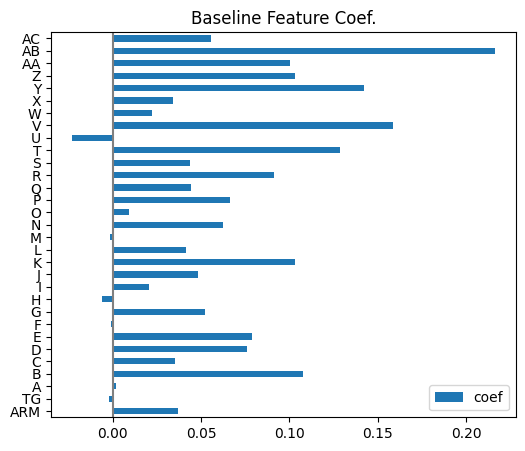

In [7]:
yj=YJ()
xy_yj=pd.DataFrame(yj.fit_transform(xy),columns=xy.columns)
x=xy_yj.iloc[:,1:]
y=xy_yj.iloc[:,0]
baseline=Ridge()
baseline.fit(x,y)
baseline_coefs=pd.DataFrame(baseline.coef_,x.columns,["coef"])
fg,ax=plt.subplots(figsize=(6,5))
baseline_coefs.plot.barh(ax=ax)
ax.axvline(x=0,color=".5")
ax.set_title("Baseline Feature Coef.")

#### 6. Agglomerate Features i: FeatureAgglomeration

In [8]:
agglo=FeatureAgglomeration(n_clusters=8)
cm_agg=pd.DataFrame(agglo.fit_transform(cm),guides_.index,list("QWERASDF"))
xy_agg=pd.concat([pe,arm,tg,cm_agg],axis=1)
yj=YJ()
xy_agg=pd.DataFrame(yj.fit_transform(xy_agg),guides_.index,xy_agg.columns)
x_agg=xy_agg.iloc[:,1:]
y_agg=xy_agg.iloc[:,0]

Text(0.5, 1.0, 'Agglomerated Baseline Feature Coef.')

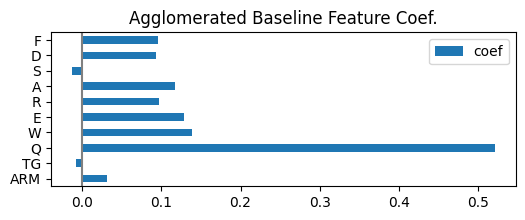

In [9]:
baseline=Ridge()
baseline.fit(x_agg,y_agg)
baseline_coefs=pd.DataFrame(baseline.coef_,x_agg.columns,["coef"])
fg,ax=plt.subplots(figsize=(6,2))
baseline_coefs.plot.barh(ax=ax)
ax.axvline(x=0,color=".5")
ax.set_title("Agglomerated Baseline Feature Coef.")

In [10]:
kfold=RepeatedKFold(n_splits=10,n_repeats=10,random_state=2330)
cv=cross_validate(Ridge(),x_agg,y_agg,cv=kfold,scoring="r2",return_estimator=True,n_jobs=-1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'Coef. Importance Volatility, KFold=100')

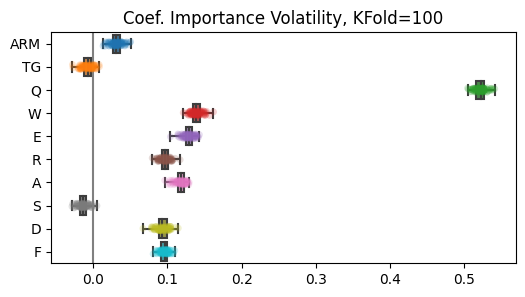

In [11]:
cv_coefs=pd.DataFrame(
    [cv_est.coef_*x_agg.iloc[train_idx].std()
     for cv_est,(train_idx,_)
     in zip(cv["estimator"],kfold.split(x_agg))],
    columns=x_agg.columns
)
plt.subplots(figsize=(6,3))
sns.stripplot(cv_coefs,orient="h",alpha=.2)
sns.boxplot(cv_coefs,orient="h",saturation=.5,whis=10)
plt.axvline(x=0,color=".5")
plt.title(f"Coef. Importance Volatility, KFold={cv_coefs.shape[0]}")

#### 7. Agglomerate Features ii: RFECV

* [Bad results](https://arxiv.org/ftp/arxiv/papers/2008/2008.07361.pdf)

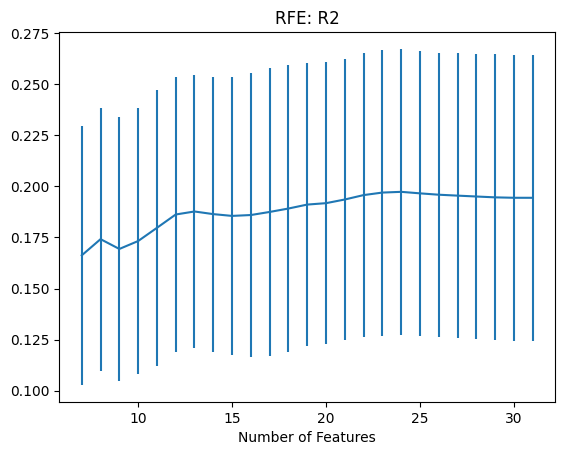

In [12]:
rfecv_estimator=Ridge(76.872595)
rfecv=RFECV(
    estimator=rfecv_estimator,
    step=1,
    cv=kfold,
    scoring="r2",
    min_features_to_select=7,
    n_jobs=-1,
)
rfecv.fit(x,y)
scores=rfecv.cv_results_["mean_test_score"]
plt.figure()
plt.xlabel("Number of Features")
plt.errorbar(
    range(7,len(scores) + 7),
    scores,
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("RFE: R2")
plt.show()

In [13]:
rfecv.support_

array([ True, False, False,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

#### 8. Get Alpha

In [14]:
alphas=np.logspace(-2,5,500)
per_alpha=[]
for alpha in alphas:
    _cv=cross_validate(Ridge(alpha),x_agg,y,scoring="r2",return_estimator=True,n_jobs=-1)
    _cv_coef=[est.coef_ for est in _cv["estimator"]]
    _cv_coef_mean=np.mean(_cv_coef,axis=0)
    _cv_score_mean=np.mean(_cv["test_score"])
    per_alpha.append((np.array([alpha]),np.array([_cv_score_mean]),_cv_coef_mean))
    del _cv["estimator"]

per_alpha_df_cols=["alpha","score"]
per_alpha_df_cols.extend(x_agg.columns)
per_alpha_df=pd.DataFrame([np.concatenate(q) for q in per_alpha],columns=per_alpha_df_cols)

(Text(0.5, 0, 'Alpha'), Text(0, 0.5, 'Coef.'))

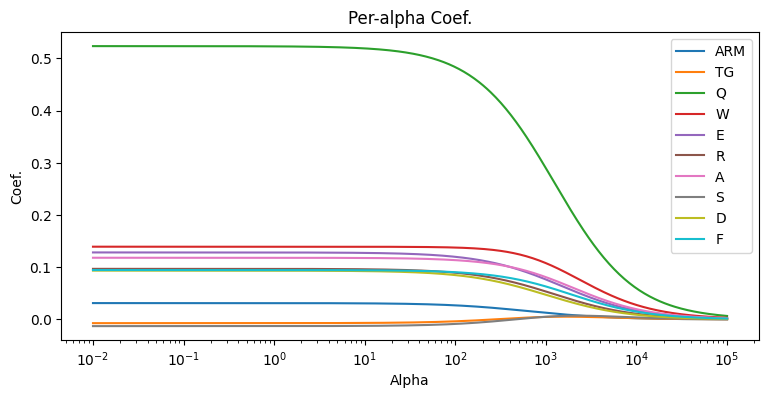

In [15]:
plt.figure(figsize=(9,4))
plt.semilogx(per_alpha_df.alpha,per_alpha_df.iloc[:,2:])
plt.legend(x_agg.columns)
plt.title("Per-alpha Coef.")
plt.xlabel("Alpha"),plt.ylabel("Coef.")

Text(0.5, 1.0, 'Per-alpha R2')

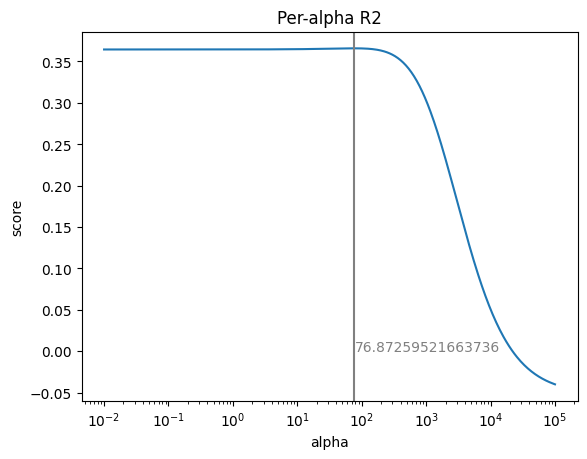

In [16]:
_alpha_best=per_alpha_df.alpha[per_alpha_df.score.idxmax()]
_p=sns.lineplot(x=per_alpha_df.alpha,y=per_alpha_df.score)
_p.set_xscale("log")
_p.axvline(x=_alpha_best,color=".5")
_p.text(_alpha_best,0,_alpha_best,color=".5")
_p.set_title("Per-alpha R2")

#### 8. Main Model

In [17]:
RIDGE=Ridge(76.872595)
RIDGE.fit(x_agg,y_agg)

Ridge(alpha=76.872595)

(Text(0.5, 0, 'Coef.'), Text(0, 0.5, 'Feature'))

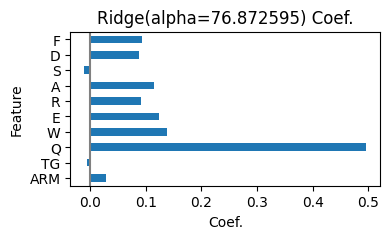

In [18]:
fg,ax=plt.subplots(figsize=(4,2))
pd.DataFrame(RIDGE.coef_,index=x_agg.columns,columns=["Coef."]).plot.barh(ax=ax,legend=0)
plt.axvline(color=".5")
plt.title(f"{RIDGE} Coef.")
plt.xlabel("Coef."),plt.ylabel("Feature")

* This isn't important as those are for every long-term mental illness
* Trial intervention (ARM) and phenotype condition (TG) didn't make it well
    * Intervention is by affecting medical doctor's action
    * Per-phenotype guideline wasn't important as consistent administration
* Dataset is valuable as it's originated from the clinical trial